### SERVAL MODEL EVALUATION

Here we will evaluate an exciting sound classification model for Sensing Clues SERVAL sound sensor.

Load the holdout set.
Create spectrograms if not already available.
Load trained model.
Run model against holdout set.
Evaluate results.

In [1]:
import json
import logging
import os
import time
import warnings

import librosa
import numpy as np
import pandas as pd
import pydub
import sklearn.preprocessing

from tqdm import tqdm

import h5py as h5py

from config import *

In [6]:
# setup and prepare audio files
np.random.seed(1)

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

# Load dataset labels
meta = pd.read_csv('dataset/meta-test-data.csv')
labels = pd.unique(meta.sort_values('category')['category'])
le = sklearn.preprocessing.LabelEncoder()
le.fit(labels)

# Generate spectrograms
logger.info('Generating spectrograms...')

if not os.path.exists('dataset/tmp/'):
    os.mkdir('dataset/tmp/')

for row in tqdm(meta.itertuples(), total=len(meta)):
    spec_file = 'dataset/tmp/' + row.filename + '.spec.npy'
    audio_file = 'dataset/audio/' + row.filename

    if os.path.exists(spec_file):
        continue

    audio = pydub.AudioSegment.from_file(audio_file).set_frame_rate(SAMPLING_RATE).set_channels(1)
    audio = (np.fromstring(audio._data, dtype="int16") + 0.5) / (0x7FFF + 0.5)

    spec = librosa.feature.melspectrogram(audio, SAMPLING_RATE, n_fft=FFT_SIZE,
                                          hop_length=CHUNK_SIZE, n_mels=MEL_BANDS)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')  # Ignore log10 zero division
        spec = librosa.core.perceptual_weighting(spec, MEL_FREQS, amin=1e-5, ref_power=1e-5,
                                                 top_db=None)

    spec = np.clip(spec, 0, 100)
    np.save(spec_file, spec.astype('float16'), allow_pickle=False)


INFO:__main__:Generating spectrograms...
  4%|▍         | 10/225 [00:00<00:13, 16.38it/s]DEBUG:pydub.converter:subprocess.call(['avconv', '-y', '-i', '/tmp/tmpo0_vr488', '-vn', '-f', 'wav', '/tmp/tmpfp4_kxlg'])
DEBUG:pydub.converter:subprocess.call(['avconv', '-y', '-i', '/tmp/tmplfpayx4t', '-vn', '-f', 'wav', '/tmp/tmpb73u19wh'])
 31%|███       | 70/225 [00:03<00:05, 26.97it/s]DEBUG:pydub.converter:subprocess.call(['avconv', '-y', '-i', '/tmp/tmpr9dvy64d', '-vn', '-f', 'wav', '/tmp/tmpwsbanthv'])
DEBUG:pydub.converter:subprocess.call(['avconv', '-y', '-i', '/tmp/tmpuodnw8eb', '-vn', '-f', 'wav', '/tmp/tmpfmzdtm_e'])
 32%|███▏      | 73/225 [00:03<00:06, 22.73it/s]DEBUG:pydub.converter:subprocess.call(['avconv', '-y', '-i', '/tmp/tmphu6o247v', '-vn', '-f', 'wav', '/tmp/tmppnk1enq8'])
DEBUG:pydub.converter:subprocess.call(['avconv', '-y', '-i', '/tmp/tmp6kd3aupp', '-vn', '-f', 'wav', '/tmp/tmp30xh9ykz'])
 39%|███▉      | 88/225 [00:03<00:06, 20.91it/s]DEBUG:pydub.converter:subprocess.ca

In [7]:
# functions to build a dataset

def to_one_hot(targets, class_count):
    """Encode target classes in a one-hot matrix.
    """
    one_hot_enc = np.zeros((len(targets), class_count))

    for r in range(len(targets)):
        one_hot_enc[r, targets[r]] = 1

    return one_hot_enc


def extract_segment(filename):
    """Get one random segment from a recording.
    """
    spec = np.load('dataset/tmp/' + filename + '.spec.npy').astype('float32')

    offset = np.random.randint(0, np.shape(spec)[1] - SEGMENT_LENGTH + 1)
    spec = spec[:, offset:offset + SEGMENT_LENGTH]

    return np.stack([spec])


def iterrows(dataframe):
    """Iterate over a random permutation of dataframe rows.
    """
    while True:
        for row in dataframe.iloc[np.random.permutation(len(dataframe))].itertuples():
            yield row


def iterbatches(batch_size, training_dataframe):
    """Generate training batches.
    """
    itrain = iterrows(training_dataframe)

    while True:
        X, y = [], []

        for i in range(batch_size):
            row = next(itrain)
            X.append(extract_segment(row.filename))
            y.append(le.transform([row.category])[0])

        X = np.stack(X)
        y = to_one_hot(np.array(y), len(labels))
        
        # TODO why do we standardize in this way?
        X -= AUDIO_MEAN
        X /= AUDIO_STD

        yield X, y


In [8]:
# Get validation data
batch_size = 250

generator = iterbatches(batch_size, meta)

In [9]:
batch = next(generator)


In [10]:
# Load model
logger.info('Load model...')

# load model
THEANO_FLAGS = ('device=cpu,'
                'floatX=float32,'
                'dnn.conv.algo_bwd_filter=deterministic,'
                'dnn.conv.algo_bwd_data=deterministic')

os.environ['THEANO_FLAGS'] = THEANO_FLAGS
os.environ['KERAS_BACKEND'] = 'theano'

import keras
keras.backend.set_image_dim_ordering('th')

# open model form current directory
with open('model.json', 'r') as file:
    cfg = file.read()
    model = keras.models.model_from_json(cfg)

model.load_weights('model.h5')
logger.debug('Loaded Keras model with weights.')

INFO:__main__:Load model...
Using Theano backend.
DEBUG:__main__:Loaded Keras model with weights.


In [11]:
# compile model
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 78, 98)        800       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 80, 78, 98)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 80, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 160, 24, 30)       115360    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 160, 24, 30)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 160, 8, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 240, 6, 8)         345840    
__________

In [12]:
# get data from batch
X = batch[0]
Y = batch[1]
# evaluate the model
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


acc: 75.60%


In [10]:
scores

[1.3053084850311278, 0.89000000000000001]

In [13]:
# calculate predictions
predictions = model.predict(X)

In [16]:
# class vector of predicted class indexes
y_pred = [np.argmax(r) for r in predictions]

In [17]:
#predictions[0] == max(predictions[0])
# from one_hot to class labels
y_test = [np.argmax(r) for r in Y]


In [18]:

from sklearn.metrics import confusion_matrix
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print(cnf_matrix)

[[ 8  2  0  0  0  0  1  0  0  0  0  0  0  0  2  1]
 [ 0  8  0  0  0  0  1  0  0  0  0  1  0  0  1  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  1  0  4  0  0  0  0]
 [ 0  0  0  0  4  0  1  0  0  0  0  1  0  0  6  0]
 [ 0  1  0  0  0  5  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  1  0  0  0  9  0  0  1  0  0  2  5  0]
 [ 0  0  0  0  0  0  0  0 54  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0 10  0  0  1  0  0  1]
 [ 0  0  0  1  0  0  0  0  0  1 12  1  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2 10  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  9  0  0  1]
 [ 0  1  0  0  0  0  1  2  0  0  0  0  0  8  1  1]
 [ 0  1  0  0  2  0  1  0  0  0  0  0  0  1 13  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  3  0  0 12]]


Confusion matrix, without normalization


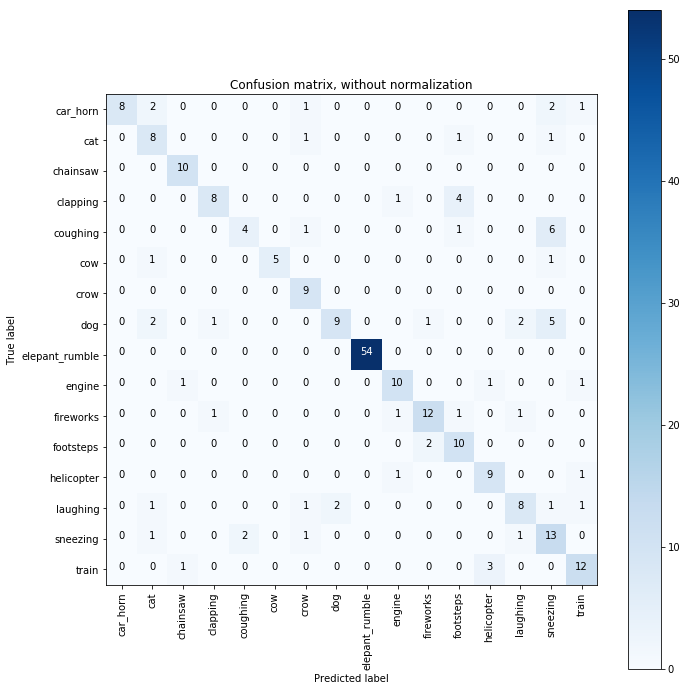

In [19]:
%matplotlib inline

import itertools

import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plot non-normalized confusion matrix

# set size
width = 10
height = 10
plt.figure(figsize=(width, height))

#plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization')


plt.show()